In [5]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import joblib

# Dataset for comparison & Sample

In [42]:
# Load dataset
df = pd.read_csv("../Clean Data/Clean_Regression_Dataset_With_Cost.csv")

# Randomly sample 100 entries
sample = df.sample(n=100, random_state=42).reset_index(drop=True)

# Define functions
def predict_climate_score(lat, lon, month):
    query = np.array([[lat, lon, month]], dtype=float)
    return float(climate_model.predict(query)[0])

# Climate Model Definition

In [ ]:
# Load models
climate_model_path = "../Model/Exports/Climate Model/knn_model.joblib"
climate_model = joblib.load(climate_model_path)

# Single Model

In [54]:

def predict_consumption_sm(lat, lon, lane_count, month):
    consumption_model_path = "../Model/Exports/Consumption Model/random_forest_consumption_model_location_lane_month.pkl"
    consumption_model = joblib.load(consumption_model_path)

    query = pd.DataFrame([{
        "Latitude": lat,
        "Longitude": lon,
        "Lane Count": lane_count,
        "Month": month
    }])
    return float(consumption_model.predict(query)[0])

### Calculate Accuracy (Single Model)

In [55]:
# Run predictions and store results
predictions = []
actuals = []

for _, row in sample.iterrows():
    pred = predict_consumption_sm(row["Latitude"], row["Longitude"], row["Lane Count"], row["Month"])
    predictions.append(pred)
    actuals.append(row["Estimated Monthly Consumption (kWh)"])

# Convert to numpy for metrics
predictions = np.array(predictions)
actuals = np.array(actuals)

# Evaluate
mae = mean_absolute_error(actuals, predictions)
mean_actual = np.mean(actuals)
accuracy = 1 - (mae / mean_actual)

# Print Results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Approximate Accuracy: {accuracy:.2%}")

Mean Absolute Error (MAE): 46.82
Approximate Accuracy: 97.00%


# Dual Model

In [56]:
def predict_consumption_dm(lat, lon, lane_count, month):
    consumption_model_path = "../Model/Exports/Consumption Model/random_forest_consumption_model_location_month_lane_climate.pkl"
    consumption_model = joblib.load(consumption_model_path)

    climate_score = predict_climate_score(lat, lon, month)
    query = pd.DataFrame([{
        "Latitude": lat,
        "Longitude": lon,
        "Lane Count": lane_count,
        "Month": month,
        "ClimateType": climate_score
    }])
    return float(consumption_model.predict(query)[0])

### Calculate Accuracy (Dual Model)

In [ ]:
# Run predictions
predictions = []
actuals = []

for _, row in sample.iterrows():
    pred = predict_consumption_dm(row["Latitude"], row["Longitude"], row["Lane Count"], row["Month"])
    predictions.append(pred)
    actuals.append(row["Estimated Monthly Consumption (kWh)"])

# Convert to numpy for metrics
predictions = np.array(predictions)
actuals = np.array(actuals)

# Evaluation
mae = mean_absolute_error(actuals, predictions)
mean_actual = np.mean(actuals)
accuracy = 1 - (mae / mean_actual)

# Output results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Approximate Accuracy: {accuracy:.2%}")

Mean Absolute Error (MAE): 38.18
Approximate Accuracy: 97.57%


# Dual Minimal Model

In [58]:
# Define functions
def predict_consumption_dmm(lat, lon, month, lane_count):
    consumption_model_path = "../Model/Exports/Consumption Model/random_forest_consumption_model_lane_climate.pkl"
    consumption_model = joblib.load(consumption_model_path)

    climate_score = predict_climate_score(lat, lon, month)
    query = pd.DataFrame([{
        "Lane Count": lane_count,
        "ClimateType": climate_score
    }])
    return float(consumption_model.predict(query)[0])

In [59]:
# Run predictions and store results
predictions = []
actuals = []

for _, row in sample.iterrows():
    pred = predict_consumption_dmm(row["Latitude"], row["Longitude"], row["Month"], row["Lane Count"])
    predictions.append(pred)
    actuals.append(row["Estimated Monthly Consumption (kWh)"])

# Evaluation
predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
mean_actual = np.mean(actuals)
accuracy = 1 - (mae / mean_actual)

# Output
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Approximate Accuracy: {accuracy:.2%}")

Mean Absolute Error (MAE): 124.44
Approximate Accuracy: 92.09%


# Evaluate Models

## Precalculated Values

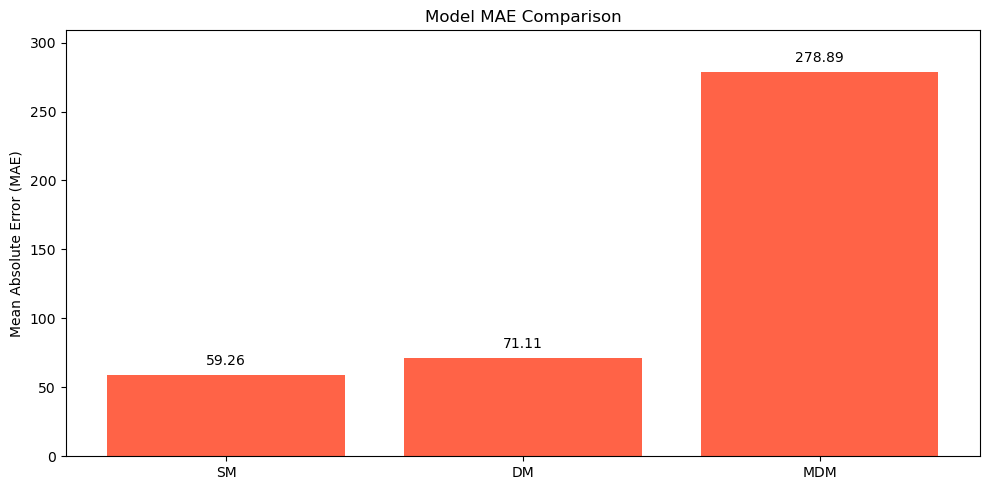

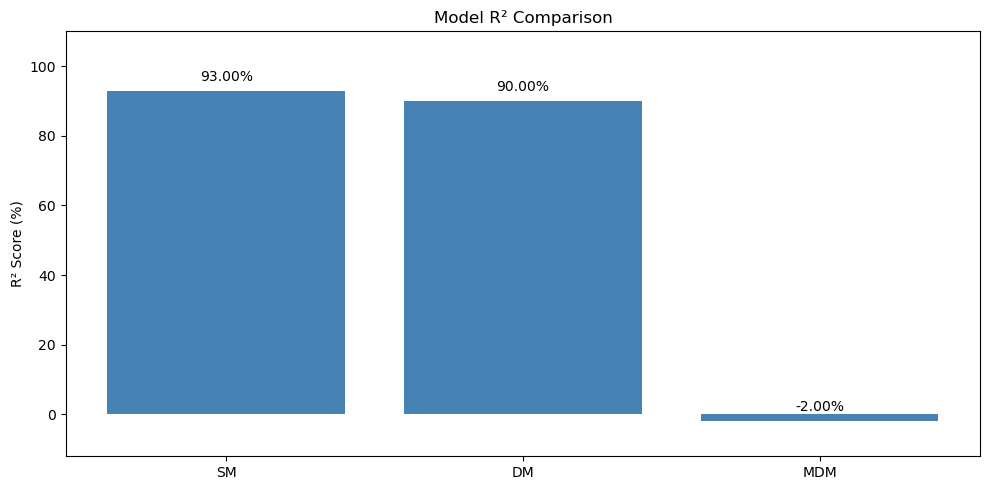

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Define metrics
metrics = {
    "SM": {"MAE": 59.26, "R2": 0.93},
    "DM": {"MAE": 71.11, "R2": 0.90},
    "MDM": {"MAE": 278.89, "R2": -0.02}
}

# Extract values
models = list(metrics.keys())
mae_values = [metrics[m]["MAE"] for m in models]
r2_values = [metrics[m]["R2"] * 100 for m in models]  # Convert to %

# Plot MAE
plt.figure(figsize=(10, 5))
plt.bar(models, mae_values, color='tomato')
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Model MAE Comparison")
for i, val in enumerate(mae_values):
    plt.text(i, val + 5, f"{val:.2f}", ha='center', va='bottom')
plt.ylim(0, max(mae_values) + 30)
plt.tight_layout()
plt.show()

# Plot R²
plt.figure(figsize=(10, 5))
plt.bar(models, r2_values, color='steelblue')
plt.ylabel("R² Score (%)")
plt.title("Model R² Comparison")
for i, val in enumerate(r2_values):
    plt.text(i, val + 2, f"{val:.2f}%", ha='center', va='bottom')
plt.ylim(min(r2_values) - 10, 110)
plt.tight_layout()
plt.show()


## Freshly Calculated

In [60]:
from sklearn.metrics import mean_absolute_error
import numpy as np

def evaluate_models(dataset):
    results = {}

    # Sample 100 rows from dataset
    sample = dataset.sample(n=100, random_state=42).reset_index(drop=True)

    # Loop over models
    for name, func in {
        "SM": predict_consumption_sm,
        "DM": predict_consumption_dm,
        "DMM": predict_consumption_dmm
    }.items():
        predictions = []
        actuals = []

        for _, row in sample.iterrows():
            lat = row["Latitude"]
            lon = row["Longitude"]
            lane = row["Lane Count"]
            month = row["Month"]
            actual = row["Estimated Monthly Consumption (kWh)"]

            if name == "DMM":
                pred = func(lat, lon, month, lane)
            else:
                pred = func(lat, lon, lane, month)

            predictions.append(pred)
            actuals.append(actual)

        mae = mean_absolute_error(actuals, predictions)
        mean_actual = np.mean(actuals)
        accuracy = 1 - (mae / mean_actual)
        results[name] = {"MAE": mae, "Accuracy": accuracy}

    return results


In [68]:
df = pd.read_csv("../Clean Data/regression_dataset.csv")
metrics = evaluate_models(df)

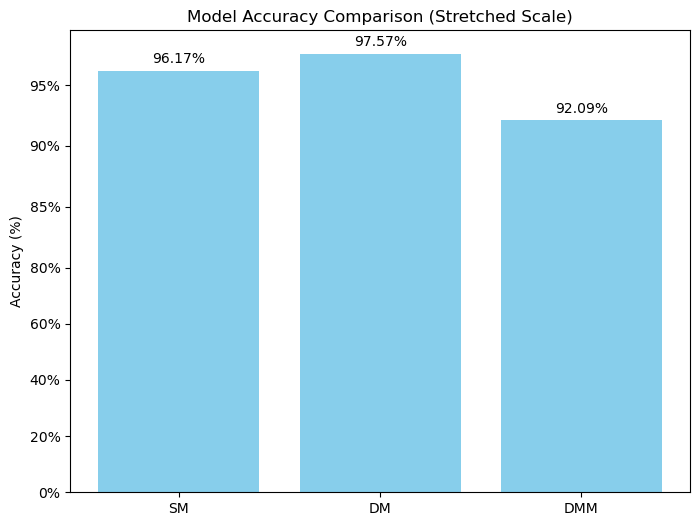

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy data
models = list(metrics.keys())
accuracies = [metrics[m]['Accuracy'] * 100 for m in models]

# Custom scale function (squash values < 80, stretch > 80)
def scale_accuracy(val):
    if val <= 80:
        return val * 0.6  # compress lower part
    else:
        return 48 + (val - 80) * 2.6  # stretch upper part

scaled_accuracies = [scale_accuracy(v) for v in accuracies]

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(models, scaled_accuracies, color='skyblue')

# Custom Y-axis ticks (real values, not scaled)
yticks_real = [0, 20, 40, 60, 80, 85, 90, 95, 100]
yticks_scaled = [scale_accuracy(y) for y in yticks_real]
plt.yticks(yticks_scaled, [f"{y}%" for y in yticks_real])
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison (Stretched Scale)")

# Annotate real values on bars
for i, val in enumerate(accuracies):
    plt.text(i, scale_accuracy(val) + 1, f"{val:.2f}%", ha='center', va='bottom')

plt.ylim(0, max(scaled_accuracies) + 5)
plt.show()
